In [11]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter.BaseFilter import BaseFilter, awgn

(336567,)


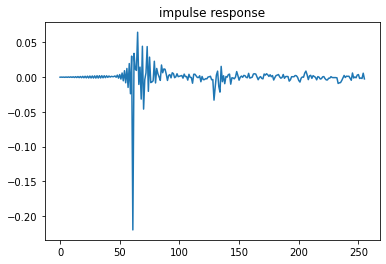

In [29]:
# load source single and rir
src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
print(src.shape)
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
rir = rir[200:]

filter_len = 256

rir = rir[:filter_len, np.newaxis]
plt.figure()
plt.plot(rir)
plt.title('impulse response')
plt.show()

(336567,)


100%|██████████| 336567/336567 [00:23<00:00, 14290.15it/s]


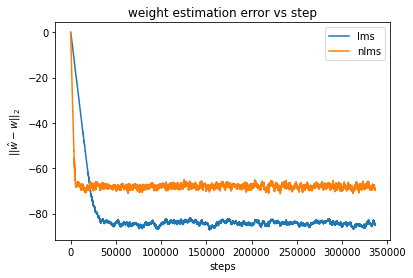

In [28]:


# src = awgn(src, 30)
print(src.shape)

SNR = 20
data_clean = conv(src, rir[:, 0])
data = data_clean[:len(src)]
data = awgn(data, SNR)

w = np.zeros((filter_len, 1))

lms = BaseFilter(filter_len=filter_len, mu=0.001, normalization=False)
nlms = BaseFilter(filter_len=filter_len, mu=0.1)

est_err_lms = np.zeros(np.size(data))
est_err_nlms = np.zeros(np.size(data))

for n in tqdm(range((len(src)))):
    _, w_lms = lms.update(src[n], data[n])
    _, w_nlms = nlms.update(src[n], data[n])
    est_err_lms[n] = np.sum(np.abs(rir - w_lms[:len(rir)])**2)
    est_err_nlms[n] = np.sum(np.abs(rir - w_nlms[:len(rir)])**2)

plt.figure()
plt.plot(10 * np.log(est_err_lms / np.sum(np.abs(rir[:, 0])**2) + 1e-12))
plt.plot(10 * np.log(est_err_nlms / np.sum(np.abs(rir[:, 0])**2)) + 1e-12)
plt.legend(['lms', 'nlms'], loc='upper right')
plt.xlabel("steps")
plt.ylabel("$\||\hat{w}-w\||_2$")
plt.title('weight estimation error vs step')
plt.show()